1 - Do adversatial attack on pretrained ResNet-50

2 - Compare required L-1, L-2 and L-infinity norms between attacks on ResNet-50 and ResNet-18. Are there any differences?

3 - Try new attacks. Use attacks from foolbox: PGD, AdamPGD, DeepFoolAttack or any other. 
Find attack with lowest L-1 for
                             the Misclassification()
                             and TargetClassProbability(666, 0.99).
 Not all of attacks will work in all cases, so dont panic, and just put marks about it.

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50
import numpy as np
import json

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
with open("imagenet1000_clsidx_to_labels.json") as f:
    imagenet_labels = json.load(f)
    # Keys in json file always stored as strings
    imagenet_labels = {int(k): v for k, v in imagenet_labels.items()}

#print first 12 labels
for label in list(imagenet_labels)[:12]:
    print(f"Label {label:3d} : {imagenet_labels[label]}")

print("...")

#print last 12 labels
for label in list(imagenet_labels)[-12:]:
    print(f"Label {label:3d} : {imagenet_labels[label]}")

Label   0 : tench, Tinca tinca
Label   1 : goldfish, Carassius auratus
Label   2 : great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
Label   3 : tiger shark, Galeocerdo cuvieri
Label   4 : hammerhead, hammerhead shark
Label   5 : electric ray, crampfish, numbfish, torpedo
Label   6 : stingray
Label   7 : cock
Label   8 : hen
Label   9 : ostrich, Struthio camelus
Label  10 : brambling, Fringilla montifringilla
Label  11 : goldfinch, Carduelis carduelis
...
Label 988 : acorn
Label 989 : hip, rose hip, rosehip
Label 990 : buckeye, horse chestnut, conker
Label 991 : coral fungus
Label 992 : agaric
Label 993 : gyromitra
Label 994 : stinkhorn, carrion fungus
Label 995 : earthstar
Label 996 : hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa
Label 997 : bolete
Label 998 : ear, spike, capitulum
Label 999 : toilet tissue, toilet paper, bathroom tissue


In [3]:
model18 = resnet18(pretrained=True)
model50 = resnet50(pretrained=True)
# Put model to the "evaluation" mode. 
model18 = model18.eval()
model50 = model50.eval()

model18 = model18.to(device)
model50 = model50.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 21.8MB/s]


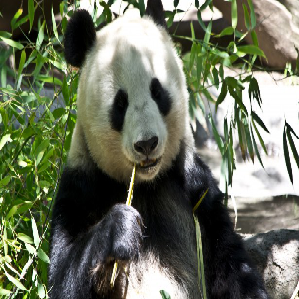

In [4]:
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        # resize image to 299 pixels in width and hight
        transforms.Resize((299,299)),
        
        # transorm "Image" object to "tensor" onject. Used when working with PIL.Image
        transforms.ToTensor(),
        
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

initial_image = Image.open("panda.jpg")
initial_image = initial_image.resize((299, 299)) 
initial_image

In [5]:
def print_prediction(image, model):
    normalized_image = transform(image).unsqueeze(0).to(device)
    prediction = model(normalized_image)[0]
    predicted_class = prediction.argmax(-1).cpu().numpy()
    print(f"Predicted class {int(predicted_class)} : {imagenet_labels[int(predicted_class)]}")
    print(f"Probability: {torch.softmax(prediction, -1)[predicted_class]:.4f}")# Transform PIL.Image to normalized PyTorch tensor 

print("model_18: ")
print_prediction(initial_image, model18)
print("\nmodel_50: ")
print_prediction(initial_image, model50)

model_18: 
Predicted class 388 : giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
Probability: 0.9891

model_50: 
Predicted class 388 : giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
Probability: 0.9590


In [6]:
!pip install foolbox

     |████████████████████████████████| 1.9MB 3.4MB/s 
     |████████████████████████████████| 460kB 20.1MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
  Created wheel for foolbox: filename=foolbox-2.3.0-cp36-none-any.whl size=1926239 sha256=42b173dcda0aa11d95a9b095624bc298f8cb7a49dc28418c357fed60d35c101c
  Stored in directory: /root/.cache/pip/wheels/3a/e4/a4/b6a9e61a9729c442383d774328091f69d9235268401a1c9524
Successfully built foolbox


In [0]:
import foolbox
from foolbox.models import PyTorchModel
from foolbox.attacks import L2BasicIterativeAttack
from foolbox.criteria import Misclassification, ConfidentMisclassification, TargetClassProbability
fb_model_18 = PyTorchModel(
    model18, 
    bounds=(-4, +4), 
    num_classes=1000,
    channel_axis=1,
)
fb_model_50 = PyTorchModel(
    model50, 
    bounds=(-4, +4),
    num_classes=1000,
    channel_axis=1
)

In [0]:
def restore_image(image):
    # Move chanel axis [3, 299, 299] -> [299, 299, 3]
    new_image = np.rollaxis(np.rollaxis((image), 2), 2)
    
    new_image = (new_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    new_image = new_image * 255
    new_image = np.clip(new_image, 0, 255)
    
    # Put image to the "byte" format. 
    # That`s required by PIL.Image to be abble to restore image from numpy array
    new_image = new_image.astype(np.uint8)
    return new_image

def generate_adversarial(foolbox_model, trained_model, attack, selected_criterion, image, pgd=False):
    if pgd:
        attack = attack(model=foolbox_model,
                        criterion=selected_criterion,
                        distance = foolbox.distances.Linfinity)
    else:
        attack = attack(model=foolbox_model,
                        criterion=selected_criterion)
    
    normalized_image = transform(image).unsqueeze(0).to(device)
    prediction = trained_model(normalized_image)[0]
    predicted_class = prediction.argmax(-1).cpu().numpy()
    
    normalazed_input_numpy = normalized_image.cpu().numpy()
    predicted_labels = np.array([int(predicted_class)])

    new_images = attack(normalazed_input_numpy, labels=predicted_labels)
    
    restored_numpy_array = restore_image(new_images[0])
    restored_image = Image.fromarray(restored_numpy_array)
    return restored_image

Predicted class 7 : cock
Probability: 0.9237


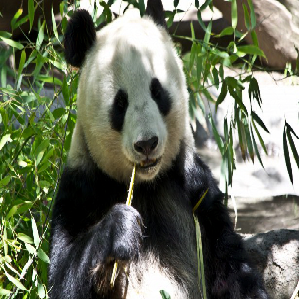

In [9]:
adv_image_18_7 = generate_adversarial(
        fb_model_18,
        model18,
        L2BasicIterativeAttack,
        TargetClassProbability(7, 0.95),
        initial_image
)

print_prediction(adv_image_18_7, model18)
adv_image_18_7

Predicted class 7 : cock
Probability: 0.9397


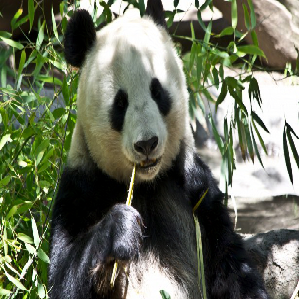

In [10]:
adv_image_50_7 = generate_adversarial(
        fb_model_50,
        model50,
        L2BasicIterativeAttack,
        TargetClassProbability(7, 0.95),
        initial_image
)

print_prediction(adv_image_50_7, model50)
adv_image_50_7

Predicted class 3 : tiger shark, Galeocerdo cuvieri
Probability: 0.9278


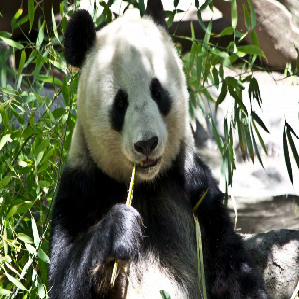

In [11]:
adv_image_18_3 = generate_adversarial(
    fb_model_18, 
    model18,
    L2BasicIterativeAttack,
    TargetClassProbability(3, 0.95), 
    initial_image
)
print_prediction(adv_image_18_3, model18)
adv_image_18_3

Predicted class 3 : tiger shark, Galeocerdo cuvieri
Probability: 0.9455


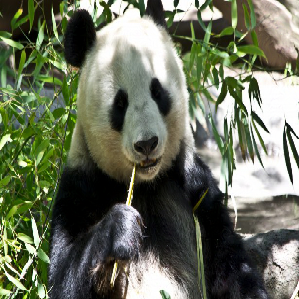

In [12]:
adv_image_50_3 = generate_adversarial(
    fb_model_50, 
    model50,
    L2BasicIterativeAttack,
    TargetClassProbability(3, 0.95), 
    initial_image
)
print_prediction(adv_image_50_3, model50)
adv_image_50_3

Predicted class 9 : ostrich, Struthio camelus
Probability: 0.9207


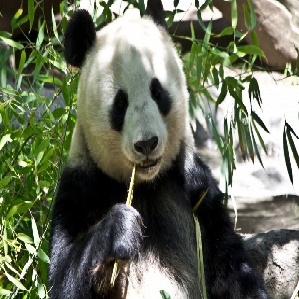

In [13]:
adv_image_18_9 = generate_adversarial(
    fb_model_18, 
    model18,
    L2BasicIterativeAttack,
    TargetClassProbability(9, 0.95), 
    initial_image
)
print_prediction(adv_image_18_9, model18)
adv_image_18_9

Predicted class 9 : ostrich, Struthio camelus
Probability: 0.9472


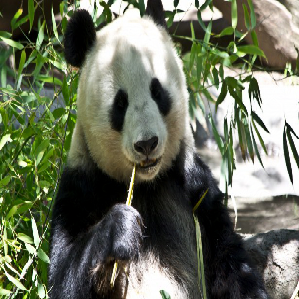

In [14]:
adv_image_50_9 = generate_adversarial(
    fb_model_50, 
    model50,
    L2BasicIterativeAttack,
    TargetClassProbability(9, 0.95), 
    initial_image
)
print_prediction(adv_image_50_9, model50)
adv_image_50_9

Predicted class 297 : sloth bear, Melursus ursinus, Ursus ursinus
Probability: 0.6664


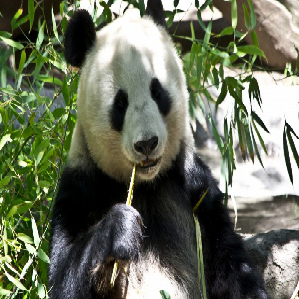

In [15]:
# Here we are not targeting particular class, but want just to change the true prediction to any other
adv_image_18_any = generate_adversarial(
    fb_model_18,
    model18, 
    L2BasicIterativeAttack,
    Misclassification(), 
    initial_image
)
print_prediction(adv_image_18_any, model18)
adv_image_18_any

Predicted class 295 : American black bear, black bear, Ursus americanus, Euarctos americanus
Probability: 0.5517


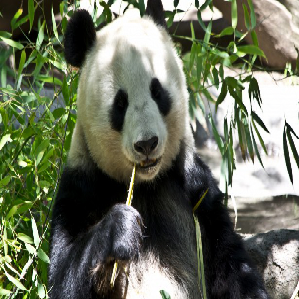

In [16]:
adv_image_50_any = generate_adversarial(
    fb_model_50,
    model50, 
    L2BasicIterativeAttack,
    Misclassification(), 
    initial_image
)
print_prediction(adv_image_50_any, model50)
adv_image_50_any

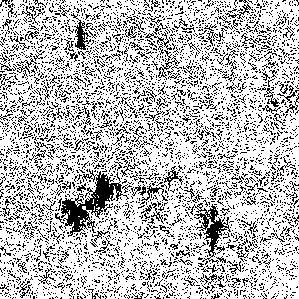

In [17]:
# Calculate the difference between initial and aversarial images
diff = np.array(adv_image_50_any).astype(int) - np.array(initial_image).astype(int)

# Find all pixels where changes was done
diff_location = diff.mean(-1) != 0
# White - pixels where the was some pertirbations
Image.fromarray((diff_location*255).astype(np.uint8))

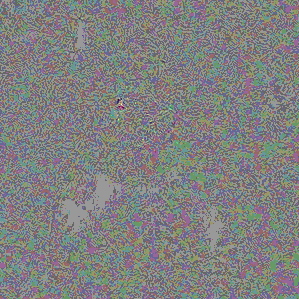

In [18]:
# Lets plot colored perturbation
# For this we need to rescale all perturbations in the diapason 0-255
scaled_diff = diff - diff.min()
scaled_diff = scaled_diff / scaled_diff.max()
# Scaled difference between initial and adversarial image
Image.fromarray((scaled_diff*255).astype(np.uint8))

In [19]:
diff = np.array(adv_image_50_any).astype(int) - np.array(initial_image).astype(int)

L1_norm = np.abs(diff).mean()
L2_norm = np.sqrt((diff**2).mean())
Linfinity_norm = np.abs(diff).max()
print(f"L1 norm: {L1_norm}, L2 norm: {L2_norm}, L-infinity norm: {Linfinity_norm}")

L1 norm: 0.48519218651543794, L2 norm: 0.6972208109664231, L-infinity norm: 3


In [0]:
L1_norms_18 = []
L2_norms_18 = []
Linf_norms_18 = []

L1_norms_50 = []
L2_norms_50 = []
Linf_norms_50 = []

for target_probabiliry in np.linspace(0.01, 0.99, 20):
    adv_image_18 = generate_adversarial(
        fb_model_18,
        model18, 
        L2BasicIterativeAttack,
        TargetClassProbability(666, target_probabiliry), 
        initial_image
    )

    adv_image_50 = generate_adversarial(
        fb_model_50,
        model50, 
        L2BasicIterativeAttack,
        TargetClassProbability(666, target_probabiliry), 
        initial_image
    )
    
    diff_18 = np.array(adv_image_18).astype(int) - np.array(initial_image).astype(int)
    
    diff_50 = np.array(adv_image_50).astype(int) - np.array(initial_image).astype(int)
    
    L1_norms_18.append(np.abs(diff_18).mean())
    L2_norms_18.append(np.sqrt((diff_18**2).mean()))
    Linf_norms_18.append(np.abs(diff_18).max())

    L1_norms_50.append(np.abs(diff_50).mean())
    L2_norms_50.append(np.sqrt((diff_50**2).mean()))
    Linf_norms_50.append(np.abs(diff_50).max())

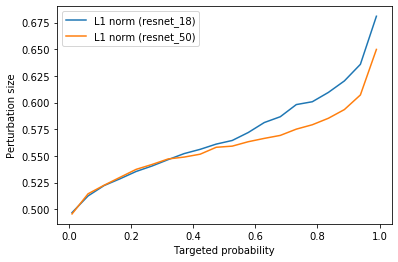

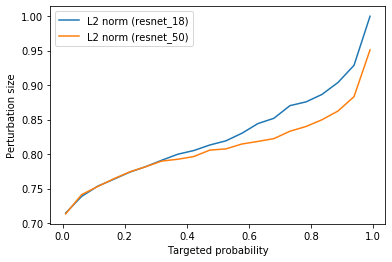

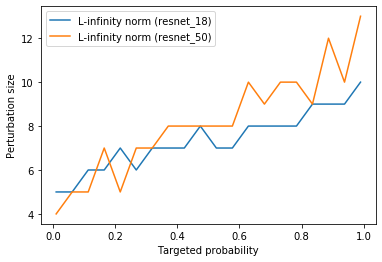

In [21]:
plt.plot(np.linspace(0.01, 0.99, 20), L1_norms_18, label="L1 norm (resnet_18)")
plt.plot(np.linspace(0.01, 0.99, 20), L1_norms_50, label="L1 norm (resnet_50)")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

plt.plot(np.linspace(0.01, 0.99, 20), L2_norms_18, label="L2 norm (resnet_18)")
plt.plot(np.linspace(0.01, 0.99, 20), L2_norms_50, label="L2 norm (resnet_50)")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

plt.plot(np.linspace(0.01, 0.99, 20), Linf_norms_18, label="L-infinity norm (resnet_18)")
plt.plot(np.linspace(0.01, 0.99, 20), Linf_norms_50, label="L-infinity norm (resnet_50)")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

Judging from L1 and L2-norm, more perturbation is required to misclassify an image in resnet-18. But, according to the plot of L-infinity norm, it is more difficult to achieve misclassification in resnet-50...

L2SasicIterative attack:
Predicted class 295 : American black bear, black bear, Ursus americanus, Euarctos americanus
Probability: 0.5477
L1_norm_L2BasicIterative =  0.4850766024242831

PGD attack: 
Predicted class 295 : American black bear, black bear, Ursus americanus, Euarctos americanus
Probability: 0.4107
L1_norm_PGD =  0.48375297815460677

AdamPGD attack:
Predicted class 295 : American black bear, black bear, Ursus americanus, Euarctos americanus
Probability: 0.3395
L1_norm_AdamPGD =  0.4849125475852246

DeepFool attack:
Predicted class 295 : American black bear, black bear, Ursus americanus, Euarctos americanus
Probability: 0.7822
L1_norm_DeepFool =  0.4849983035238234


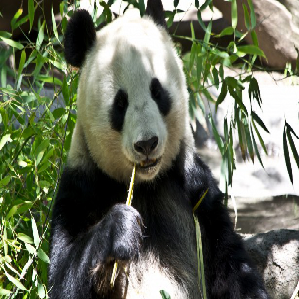

In [22]:
"""============================ MISCLASSIFICATION =========================="""

from foolbox.attacks import PGD, AdamPGD, DeepFoolAttack

adv_image_L2BasicIterative = generate_adversarial(
        fb_model_50,
        model50,
        L2BasicIterativeAttack,
        Misclassification(),
        initial_image,
)
adv_image_PGD = generate_adversarial(
        fb_model_50,
        model50,
        PGD,
        Misclassification(),
        initial_image,
        pgd=True
)
adv_image_AdamPGD = generate_adversarial(
        fb_model_50,
        model50,
        AdamPGD,
        Misclassification(),
        initial_image,
        pgd=True
)
adv_image_DeepFool = generate_adversarial(
        fb_model_50,
        model50,
        DeepFoolAttack,
        Misclassification(),
        initial_image
)

diff_L2BasicIterative = np.array(adv_image_L2BasicIterative).astype(int) - np.array(initial_image).astype(int)
diff_PGD = np.array(adv_image_PGD).astype(int) - np.array(initial_image).astype(int)
diff_AdamPGD = np.array(adv_image_AdamPGD).astype(int) - np.array(initial_image).astype(int)
diff_DeepFool = np.array(adv_image_DeepFool).astype(int) - np.array(initial_image).astype(int)

L1_norm_L1BasicIterative = np.abs(diff_L2BasicIterative).mean()
L1_norm_PGD = np.abs(diff_PGD).mean()
L1_norm_AdamPGD = np.abs(diff_AdamPGD.mean())
L1_norm_DeepFool = np.abs(diff_DeepFool).mean()

print("L2SasicIterative attack:")
print_prediction(adv_image_L2BasicIterative, model50)
print("L1_norm_L2BasicIterative = ", L1_norm_L1BasicIterative)
print("\nPGD attack: ")
print_prediction(adv_image_PGD, model50)
print("L1_norm_PGD = ", L1_norm_PGD)
print("\nAdamPGD attack:")
print_prediction(adv_image_AdamPGD, model50)
print("L1_norm_AdamPGD = ", L1_norm_AdamPGD)
print("\nDeepFool attack:")
print_prediction(adv_image_DeepFool, model50)
print("L1_norm_DeepFool = ", L1_norm_DeepFool)

adv_image_L2BasicIterative

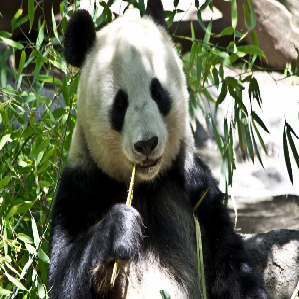

In [23]:
adv_image_PGD

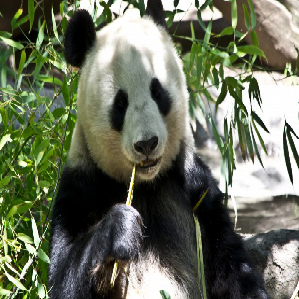

In [24]:
adv_image_AdamPGD

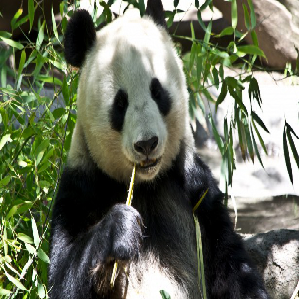

In [25]:
adv_image_DeepFool

Attack with the lowest L1_norm for Misclassification - PGD Attack (ProjectedGradientDescent Attack)

In [30]:
# ------------ TargetClassProbability Attack (666, 0.99) ------------------

adv_image_L2BasicIterative_666 = generate_adversarial(
    fb_model_50,
    model50, 
    L2BasicIterativeAttack,
    TargetClassProbability(666, 0.99), 
    initial_image,
)

adv_image_PGD_666 = generate_adversarial(
    fb_model_50,
    model50, 
    PGD,
    TargetClassProbability(666, 0.99), 
    initial_image,
    pgd=True
)

adv_image_AdamPGD_666 = generate_adversarial(
    fb_model_50,
    model50, 
    AdamPGD,
    TargetClassProbability(666, 0.99), 
    initial_image,
    pgd=True
)

diff_L2BasicIterative_666 = np.array(adv_image_L2BasicIterative_666).astype(int) - np.array(initial_image).astype(int)
diff_PGD_666 = np.array(adv_image_PGD_666).astype(int) - np.array(initial_image).astype(int)
diff_AdamPGD_666 = np.array(adv_image_AdamPGD_666).astype(int) - np.array(initial_image).astype(int)

L1_norm_L2BasicIterative_666 = np.abs(diff_L2BasicIterative_666).mean()
L1_norm_PGD_666 = np.abs(diff_PGD_666).mean()
L1_norm_AdamPGD_666 = np.abs(diff_AdamPGD_666.mean())

print("L1_norm_L2BasicIterative = {}\nL1_norm_PGD = {}\nL1_norm_AdamPGD = {}".format(L1_norm_L2BasicIterative_666,
                                                                                     L1_norm_PGD_666, 
                                                                                     L1_norm_AdamPGD_666))
print("\nL2SasicIterative attack:")
print_prediction(adv_image_L2BasicIterative_666, model50)
print("\nPGD attack: ")
print_prediction(adv_image_PGD_666, model50)
print("\nAdamPGD attack:")
print_prediction(adv_image_AdamPGD_666, model50)

L1_norm_L2BasicIterative = 0.6562081706766889
L1_norm_PGD = 0.9178383537842604
L1_norm_AdamPGD = 0.48534878431635736

L2SasicIterative attack:
Predicted class 666 : mortar
Probability: 0.9845

PGD attack: 
Predicted class 666 : mortar
Probability: 0.9911

AdamPGD attack:
Predicted class 666 : mortar
Probability: 0.9868


There was warning saying "DeepFool is an untargeted adversarial attack", so I removed the DeepFoolAttack from the code above.

Attack with the lowest L1_norm for the TargetClassProbability(666, 0.99) - AdamPGD Attack.

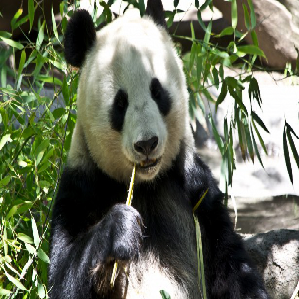

In [31]:
adv_image_L2BasicIterative

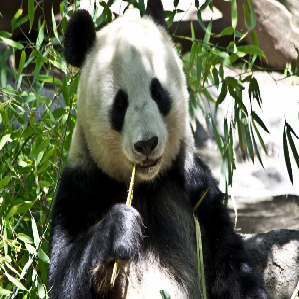

In [32]:
adv_image_PGD

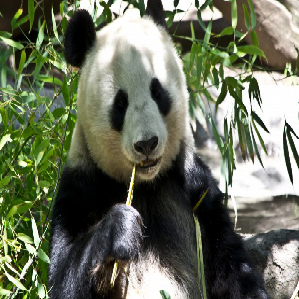

In [33]:
adv_image_AdamPGD